In [1]:
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

### Theory

##### Siamese NN

Концептуально - сиамские нейронные сети, это две одинаковые по архитектуре сети, с общим набором весов. Зачем это нужно ?  
Ответ очевиден, если указать еще одну особенность таких сетей - на выходе у них нет функции активации типа софтмакса. Их выход и есть  
вектор, который получился в результате работы сети. То есть на деле это некоторое подобие автокодировщика (на деле два автокодировщика в одной сети),  
в том смысле, что он отображает все входные данные в некоторое латентное пространство. Таким образом, если на вход сети будут поданы два  
разных объекта, условная косинусная мера покажет, что вектора далеки друг от друга -> объекты различны. И наоборот, расстояние между  
схожими объектами в латентном пространстве будет невелико и можем сделать вывод, что это один и тот же объект.  

Рассмотрим пример, когда не обойтись без сиамской нейросети. Допустим, перед нами стоит задача разблокировки двери по фотографии  
лица человека. Наивный подход был бы в том, чтобы решать задачу классификации. Взять датасет с лицами людей и пытаться классифицировать  
всех. Это хороший подход, в случае, если у нас есть несколько тысяч различных фотографий одного и того же человека. Если мы классифируем  
каких то селеб, то для некоторых из них это возможно, условный VGG датасет существует достаточно давно. Но, что если это обычные люди,   
у которых и в помине такого количества фотографий нет. Задача становится нерешаемой. Здесь выходят на сцену сиамские нейросети. Мы скормим  
поступившее фото и его вектор будет близок к одному из фото в датасете


Резюмируем: нам нужно, чтобы сеть выдавала такое кодирование f, чтобы:  
||f(a)-f(b)||^2 -> 0 если a и b из одного класса  
||f(a)-f(b)||^2 -> m если a и b из разных классов  

##### Contrastive Loss Function

теперь разберемся с функкией потерь. Как и говорилось раньше, хочется взять L2 норму векторов.  
d(a,b) = || f(a) - f(b) ||^2  
С ней есть некоторые проблемы. Что случится, если вектора отрицательны, или это разные картинки ?  Она будет расти  
Но мы не хотим, чтобы она росла до бесконечности. В идеале, она должна дорасти до какой-то границы m. Тогда формула будет выглядеть:   
d(a,b) = max(0, m^2 - || f(a) - f(b) ||^2  )  
Идея в том, что мы не хотим растаскивать a и b еще дальше, если они и так уже далеки друга от друга более чем на m  


Таким образом можем скомбинировать эти две функции и получить CLF  
d(a,b,y) =  y * || f(a) - f(b) ||^2  + (1-y) * max(0, m^2 - || f(a) - f(b) ||^2  )
y здесь это вспомогательная переменная, равная 1, если а и b одинаковые объекты и 0, иначе

Вообще есть еще функция триплетов, которая работает лучше. Да и сеть триплетов тоже существует, но о них, наверное потом 

### Practice

ну что, попробуем написать свою реализацию

Начнем с датасета. Как известно, классический датасет для компьютерного зрения берет  
выдает одну картинку и одну метку класса. Нам же нужно, чтобы датасет выдавал два  
изображения и одну метку. Для этого нужно сделать свой датасет

In [13]:
from torchvision.datasets import VisionDataset
from torchvision.datasets.folder import make_dataset, default_loader
import os 
import random

class SiameseDataset(VisionDataset):
    def __init__(self, root, transforms= None, transform = None, target_transform = None):
        super().__init__(root=root, transforms = transforms,transform=transform, target_transform=target_transform)
        curdir = next(os.walk(self.root))
        self.classes = dict([(curdir[1][i],i) for i in range(len(curdir[1]))])
        self.samples = make_dataset(self.root, self.classes, extensions='png')
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img0, label0 = random.choice(self.samples)
        isSame = random.randint(0,1)
        if isSame:
            img1, label1 = random.choice(list(filter(lambda x: x[1] != label0, self.samples)))
        else:
            img1, label1 = random.choice(list(filter(lambda x: x[1] == label0, self.samples)))
           
        img0 = default_loader(img0)
        img1 = default_loader(img1)
        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1, torch.from_numpy(np.array([int(label1 != label0)], dtype=np.float32))
        


1.0


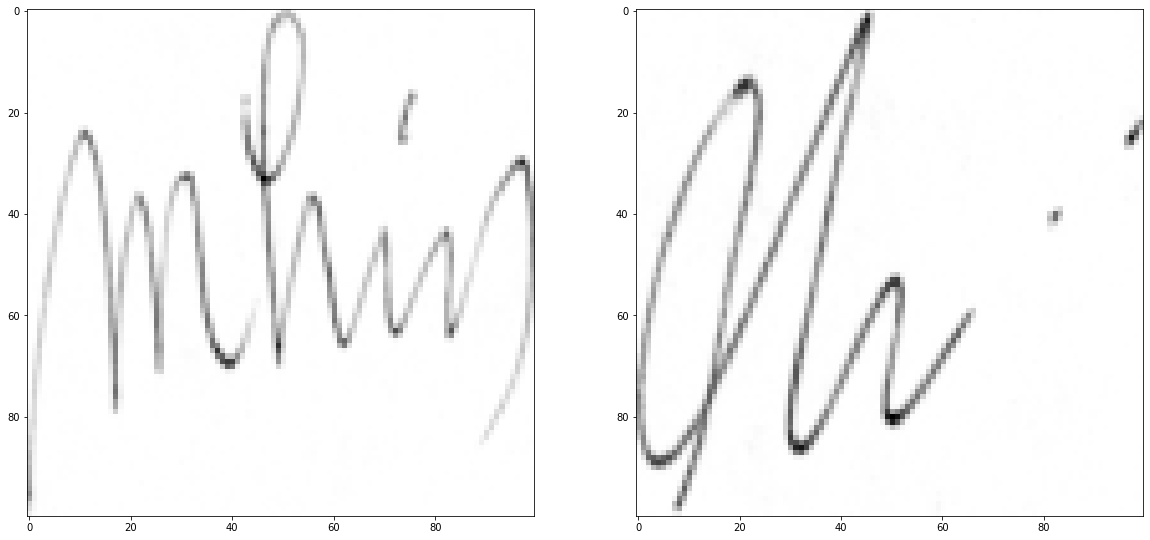

In [14]:
import torchvision.transforms as T

transforms = T.Compose([
    T.Resize((100,100)),
    T.Grayscale(),
    T.ToTensor()
])
root = "./data/sign_data/train/"
dataset = SiameseDataset(root = root, transform = transforms)
f = plt.figure(figsize =(20,20))
img0,img1,label = dataset[0]
f.add_subplot(121)
plt.imshow(img0.permute(1,2,0), cmap='gray')
f.add_subplot(122)
plt.imshow(img1.permute(1,2,0), cmap='gray')
print(label.item())

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.]])


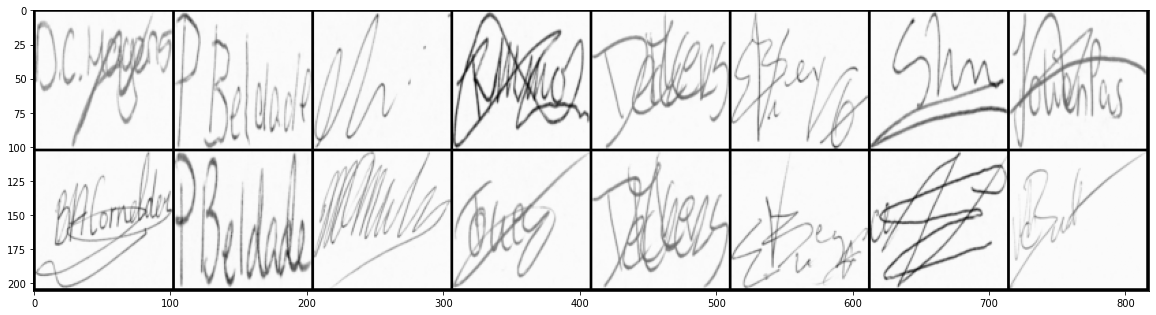

In [15]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

dl = DataLoader(dataset=dataset, batch_size=8, shuffle=True)
ex = next(iter(dl))
cat = torch.cat((ex[0],ex[1]),0)

f = plt.figure(figsize =(20,20))
img = make_grid(cat)
plt.imshow(img.permute(1,2,0), cmap='gray')
print(ex[2])


Теперь самое интересное - нейросеть

In [16]:
import torch.nn as nn 

class SiameseNN(nn.Module):
    def __init__(self):
        super(SiameseNN,self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels = 1,out_channels = 96,kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),

            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(in_channels = 256, out_channels = 384, kernel_size=3, stride=1),
            nn.ReLU(inplace=True) 
        )

        self.fc1 = nn.Sequential(
           
            nn.Linear(in_features=384, out_features=1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024,256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )
    
    def forwardOnce(self,x):
        out = self.cnn1(x)
        out = out.view(out.size()[0], -1)
        out = self.fc1(out)
        return out
    
    def forward(self, img1, img2):
        out1 = self.forwardOnce(img1)
        out2 = self.forwardOnce(img2)
        return out1,out2

Думаю очевидно, что нет смысла кодить две одинаковых нейронки. Поскольку они идентичны, можно прогнать через одну и ту же 2 изображения за раз.  
Функция потерь в любом случае учитывает представление обоих изображений и градиент будет распространяться относительно них

теперь наша функция потерь. В торче её нет, так что придется писать ручками. 

In [17]:
class ContrastiveLoss(nn.Module):
    def __init__(self, m = 2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = m
    
    def forward(self, vec1,vec2, label):
        dst = nn.functional.pairwise_distance(vec1,vec2, keepdim=True)
        return torch.mean((1-label) * torch.pow(dst, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - dst, min=0.0), 2))


In [18]:
from tqdm import tqdm

def train(model, dl , optim, lossFunc, epochs,device):
    counter = []
    lossHist = [] 
    iterationNum= 0
    for epoch in tqdm(range(epochs)):
        for batch, (img0,img1,label) in enumerate(dl):
            
            img0 = img0.to(device)
            img1 = img1.to(device)
            label = label.to(device)
            
            optim.zero_grad()
            out1,out2 = model(img0,img1)
            loss = lossFunc(out1,out2,label)
            loss.backward()
            optim.step()
            if (batch % 10 == 0):
                print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
                iterationNum += 10
                counter.append(iterationNum)
                lossHist.append(loss.item())

    return counter, lossHist, iterationNum
            

In [20]:
from torch.optim import Adam
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SiameseNN()
model = model.to(device)

transforms = T.Compose([
    T.Resize((100,100)),
    T.Grayscale(),
    T.ToTensor()
])
root = "./data/sign_data/train/"
trainingDataset = SiameseDataset(root = root, transform = transforms)

trainingDl = DataLoader(dataset=trainingDataset, batch_size=64,shuffle=True)
lossFunc = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr = 0.0005 )
epochs = 100
print(device)

cuda:0


In [ ]:
counter, lossHist, iterationNum = train(model, trainingDl,optimizer,lossFunc,epochs, device)

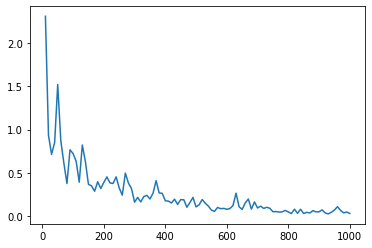

In [166]:
plt.plot(counter,lossHist)
plt.show()

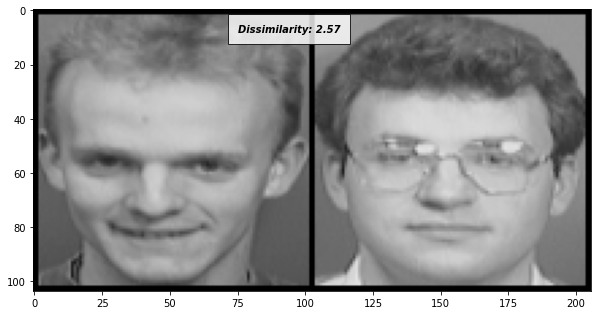

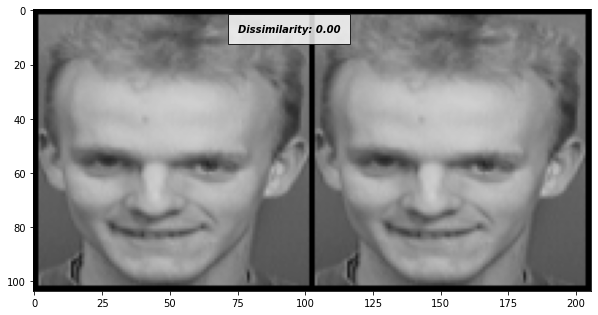

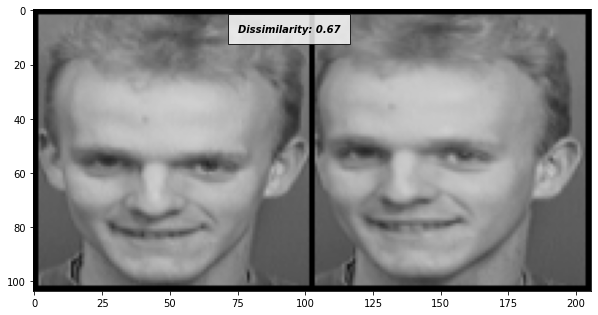

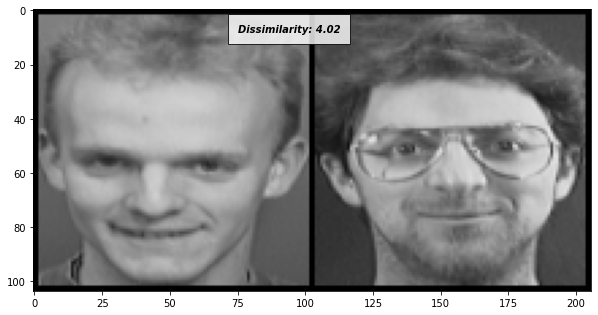

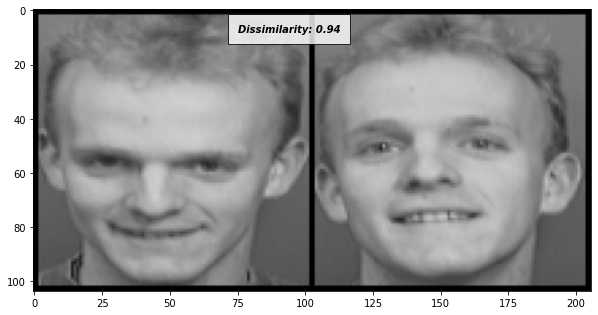

In [171]:
testingRoot = "./data/at&t/faces/testing"
transform = T.Compose([
    T.Resize((100,100)),
    T.Grayscale(),
    T.ToTensor()
])
testingDataset = SiameseDataset(root=testingRoot, transform=transform)
testingDL = DataLoader(testingDataset, batch_size=1, shuffle=True)
model.eval()
dlIterator = iter(testingDL)
image0, _, _ = next(dlIterator)
with torch.no_grad():
    for i in range(5): 
        _ , image1, label = next(dlIterator)
        out1,out2 = model(image0.to(device),image1.to(device))
        cat = torch.concat((image0,image1),0)
        dst = nn.functional.pairwise_distance(out1, out2)
        f = plt.figure(figsize=(10,10))
        plt.imshow(make_grid(cat).permute(1,2,0))
        plt.text(75, 8, f'Dissimilarity: {dst.item():.2f}', style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

